## BBM 444 - Programming Assignment 1: Camera Pipeline

* You can add as many cells as you want in-between each question.
* Please add comments to your code to explain your work.  
* Please add Markdown cells to answer the (non-coding) questions in the homework text. You can, however, refer to the outputs of code cells without adding them as images to the Markdown cell unless you are requested to do otherwise.
* Please be careful about the order of runs of cells. Doing the homework, it is likely that you will be running the cells in different orders, however, they will be evaluated in the order they appear. Hence, please try running the cells in this order before submission to make sure they work.    
* Please refer to the homework text for any implementation detail. Though you are somewhat expected to abide by the comments in the below cells, they are mainly just provided for guidance. That is, as long as you are not completely off this structure and your work pattern is understandable and traceable, it is fine. For instance, you do not have to implement a particular function within a cell just because the comment directs you to do so.
* This document is also your report. Show your work.

##  Insert personal information (Bora, Dere, 2220765021)

## 1. Implement a basic image processing pipeline (80 points)

### 1.1 Raw Image Conversion (5 points)

In [1]:
## Initialize the variables obtained with "dcraw -4 -d -v -T <RAW_filename>"

# The output:
# Loading NIKON D40 image from C:\Users\Bora\Desktop\HU\AIN434\Assignment 1\sample.NEF ...
# Scaling with darkness 0, saturation 4095, and
# multipliers 2.629696 1.000000 1.251207 1.000000
# Building histograms...
# Writing data to C:\Users\Bora\Desktop\HU\AIN434\Assignment 1\sample.tiff ...


black = 0
white = 4095

r_scale = 2.629696
g_scale = 1.000000
b_scale = 1.251207

### 1.2. Python Initials (5 points)

In [2]:
## Import necessary libraries
import skimage as ski
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

In [3]:
## Read the img and print (use skimage's imread function) how many bits per pixel the image has, its width, and its height.
## (See numpy functions shape, dtype and astype.)
image = ski.io.imread("sample.tiff")

print(f"Image has a height of {image.shape[0]} pixels, and a width of {image.shape[1]} pixels.")
print(f"Image has {image.dtype} data type. Which means it has {image.dtype.itemsize*8} bits per pixel.")

Image has a height of 2014 pixels, and a width of 3039 pixels.
Image has uint16 data type. Which means it has 16 bits per pixel.


According to the bit of research I did for this bits per pixel part, even though the data type is uint16, the meaningful bit amount is most likely less. To obtain the effective bit depth I thought of using the upper bound (white) in this manner:

In [4]:
effective_bits = int(np.log2(white + 1))
print(f"Effective bit depth: {effective_bits} bits")

Effective bit depth: 12 bits


Thus, I conclude that this camera produces 12 bit images.

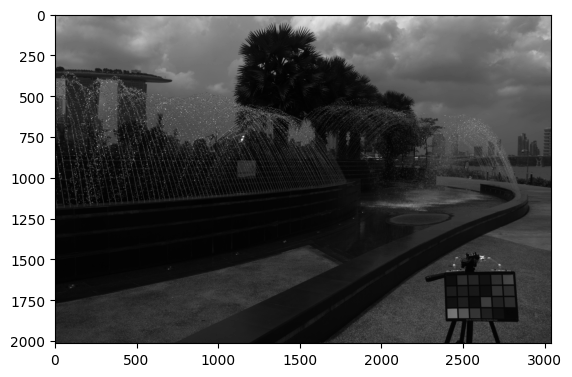

In [5]:
## Print the image
plt.imshow(image, cmap='gray')
plt.show()

In [6]:
## Convert the image into a double-precision array.
image = image.astype(float) # float is an alias for np.float64 in numpy

### 1.3. Linearization (5 points)

In [7]:
## Apply a linear transformation so that the value <black> is mapped to 0 and <white> to 1. Then, clip negative values to 0
## and values greater than 1 to 1. (See numpy function clip.)
## ( <black> and <white> values are obtained in the first step, raw image conversion ).
image = (image - black) / (white - black)
np.clip(image, 0, 1, out=image)

array([[0.5965812 , 0.79389499, 0.60781441, ..., 0.65421245, 0.87057387,
        0.66617827],
       [0.81367521, 0.36312576, 0.82026862, ..., 0.90500611, 0.4014652 ,
        0.88083028],
       [0.61367521, 0.81684982, 0.61636142, ..., 0.64835165, 0.8979243 ,
        0.65128205],
       ...,
       [0.20512821, 0.08522589, 0.19194139, ..., 0.24126984, 0.13333333,
        0.2979243 ],
       [0.12405372, 0.20659341, 0.13333333, ..., 0.15115995, 0.25396825,
        0.17777778],
       [0.18559219, 0.09401709, 0.22881563, ..., 0.28034188, 0.12551893,
        0.28424908]])

### 1.4. White Balancing (10 points)

#### In the following 3 cells you are asked to implement three different automatic white balancing algorithms. The parameters for these functions are up to you. However, please comment, stating their types and purposes.

In [8]:
def extract_bayer_channels(image: np.ndarray[float], pattern: str): # to extract the bayer patterns for experiments
    """
    Function to exxtract channels according to the assumed Bayer pattern.

    :param image: 2D np.array of floats.
    :param pattern: String representation of the assumed Bayer pattern.

    :return R, G1, G2, B: Channels according to the assumed Bayer pattern.
    """
    if pattern == 'rggb':
        R = image[0::2, 0::2]
        G1 = image[0::2, 1::2]
        G2 = image[1::2, 0::2]
        B = image[1::2, 1::2]
    elif pattern == 'grbg':
        G1 = image[0::2, 0::2]
        R = image[0::2, 1::2]
        B = image[1::2, 0::2]
        G2 = image[1::2, 1::2]
    elif pattern == 'gbrg':
        G1 = image[0::2, 0::2]
        B = image[0::2, 1::2]
        R = image[1::2, 0::2]
        G2 = image[1::2, 1::2]
    elif pattern == 'bggr':
        B = image[0::2, 0::2]
        G1 = image[0::2, 1::2]
        G2 = image[1::2, 0::2]
        R = image[1::2, 1::2]

    return R, G1, G2, B

In [9]:
## Implement a function for white world assumption automatic white balancing algorithm.
def white_world_assumption(image: np.ndarray[float], pattern: str):
    """
    Function to apply white balancing with white world assumption.

    :param image: 2D np.array of floats.
    :param pattern: String representation of the assumed Bayer pattern.

    :return balanced_image: 2D np.array of floats, represents white balanced image.
    """
    R, G1, G2, B = extract_bayer_channels(image, pattern)

    # using max since it is white world assumption
    max_G = max(np.max(G1), np.max(G2))
    scale_r = max_G / np.max(R) if np.max(R) != 0 else 1
    scale_b = max_G / np.max(B) if np.max(B) != 0 else 1

    R_balanced = R * scale_r
    G1_balanced = G1  # green channels remain unchanged
    G2_balanced = G2
    B_balanced = B * scale_b

    # clip the results to [0, 1]
    np.clip(R_balanced, 0, 1, out=R_balanced)
    np.clip(B_balanced, 0, 1, out=B_balanced)

    # reassembling the mosaic based on the Bayer pattern
    balanced_image = image.copy()  

    if pattern == 'rggb':
        balanced_image[0::2, 0::2] = R_balanced
        balanced_image[0::2, 1::2] = G1_balanced
        balanced_image[1::2, 0::2] = G2_balanced
        balanced_image[1::2, 1::2] = B_balanced
    elif pattern == 'grbg':
        balanced_image[0::2, 0::2] = G1_balanced
        balanced_image[0::2, 1::2] = R_balanced
        balanced_image[1::2, 0::2] = B_balanced
        balanced_image[1::2, 1::2] = G2_balanced
    elif pattern == 'gbrg':
        balanced_image[0::2, 0::2] = G1_balanced
        balanced_image[0::2, 1::2] = B_balanced
        balanced_image[1::2, 0::2] = R_balanced
        balanced_image[1::2, 1::2] = G2_balanced
    elif pattern == 'bggr':
        balanced_image[0::2, 0::2] = B_balanced
        balanced_image[0::2, 1::2] = G1_balanced
        balanced_image[1::2, 0::2] = G2_balanced
        balanced_image[1::2, 1::2] = R_balanced

    return balanced_image

In [10]:
## Implement a function for grey world assumption automatic white balancing algorithm.
def gray_world_assumption(image: np.ndarray[float], pattern: str):
    """
    Function to apply white balancing with gray world assumption.

    :param image: 2D np.array of floats.
    :param pattern: String representation of the assumed Bayer pattern.

    :return balanced_image: 2D np.array of floats, represents white balanced image.
    """
    R, G1, G2, B = extract_bayer_channels(image, pattern)

    # using mean since it is gray world assumption
    mean_G = (np.mean(G1) + np.mean(G2)) / 2
    scale_r = mean_G / np.mean(R) if np.mean(R) != 0 else 1
    scale_b = mean_G / np.mean(B) if np.mean(B) != 0 else 1

    R_balanced = R * scale_r
    G1_balanced = G1
    G2_balanced = G2
    B_balanced = B * scale_b

    np.clip(R_balanced, 0, 1, out=R_balanced)
    np.clip(B_balanced, 0, 1, out=B_balanced)

    balanced_image = image.copy()
    
    if pattern == 'rggb':
        balanced_image[0::2, 0::2] = R_balanced
        balanced_image[0::2, 1::2] = G1_balanced
        balanced_image[1::2, 0::2] = G2_balanced
        balanced_image[1::2, 1::2] = B_balanced
    elif pattern == 'grbg':
        balanced_image[0::2, 0::2] = G1_balanced
        balanced_image[0::2, 1::2] = R_balanced
        balanced_image[1::2, 0::2] = B_balanced
        balanced_image[1::2, 1::2] = G2_balanced
    elif pattern == 'gbrg':
        balanced_image[0::2, 0::2] = G1_balanced
        balanced_image[0::2, 1::2] = B_balanced
        balanced_image[1::2, 0::2] = R_balanced
        balanced_image[1::2, 1::2] = G2_balanced
    elif pattern == 'bggr':
        balanced_image[0::2, 0::2] = B_balanced
        balanced_image[0::2, 1::2] = G1_balanced
        balanced_image[1::2, 0::2] = G2_balanced
        balanced_image[1::2, 1::2] = R_balanced

    return balanced_image

In [11]:
## Implement a function for a white balancing algorithm, where the red, green, and blue channels are multiplied with
## <r scale>, <g scale>, and <b scale> recorded in the first step, which is the white balancing preset used by the camera.
def preset_mosaic(image: np.ndarray[float], pattern: str, r_scale: float, g_scale: float, b_scale: float):
    """
    Function to apply white balancing using the device preset.

    :param image: 2D np.array of floats.
    :param pattern: String representation of the assumed Bayer pattern.
    :param r_scale: r_scale value of the device, float.
    :param g_scale: g_scale value of the device, float.
    :param b_scale: b_scale value of the device, float.

    :return balanced_image: 2D np.array of floats, represents white balanced image.
    """
    R, G1, G2, B = extract_bayer_channels(image, pattern)

    R_balanced = R * r_scale
    G1_balanced = G1 * g_scale
    G2_balanced = G2 * g_scale
    B_balanced = B * b_scale

    np.clip(R_balanced, 0, 1, out=R_balanced)
    np.clip(B_balanced, 0, 1, out=B_balanced)

    balanced_image = image.copy()
    
    if pattern == 'rggb':
        balanced_image[0::2, 0::2] = R_balanced
        balanced_image[0::2, 1::2] = G1_balanced
        balanced_image[1::2, 0::2] = G2_balanced
        balanced_image[1::2, 1::2] = B_balanced
    elif pattern == 'grbg':
        balanced_image[0::2, 0::2] = G1_balanced
        balanced_image[0::2, 1::2] = R_balanced
        balanced_image[1::2, 0::2] = B_balanced
        balanced_image[1::2, 1::2] = G2_balanced
    elif pattern == 'gbrg':
        balanced_image[0::2, 0::2] = G1_balanced
        balanced_image[0::2, 1::2] = B_balanced
        balanced_image[1::2, 0::2] = R_balanced
        balanced_image[1::2, 1::2] = G2_balanced
    elif pattern == 'bggr':
        balanced_image[0::2, 0::2] = B_balanced
        balanced_image[0::2, 1::2] = G1_balanced
        balanced_image[1::2, 0::2] = G2_balanced
        balanced_image[1::2, 1::2] = R_balanced

    return balanced_image

In [12]:
def demosaic_bilinear(image: np.ndarray[float], pattern: str):
    """
    Function to apply bilinear demosaicing according to the assumed Bayer pattern.

    :param image: 2D np.array of floats.
    :param pattern: String representation of the assumed Bayer pattern.

    :return rgb_image: Demosaiced RGB image.
    """
    h, w = image.shape

    # grid for output
    y_full = np.arange(h)
    x_full = np.arange(w)

    grid_coords = np.array(np.meshgrid(y_full, x_full, indexing='ij')).transpose(1, 2, 0) # (h, w, 2)
    flat_coords = grid_coords.reshape(-1, 2)  # (h*w, 2)
    
    if pattern == 'rggb':
        R = image[0::2, 0::2]
        G1 = image[0::2, 1::2]
        G2 = image[1::2, 0::2]
        B = image[1::2, 1::2]
        
        y_R = np.arange(0, h, 2); x_R = np.arange(0, w, 2)
        y_G1 = np.arange(0, h, 2); x_G1 = np.arange(1, w, 2)
        y_G2 = np.arange(1, h, 2); x_G2 = np.arange(0, w, 2)
        y_B = np.arange(1, h, 2); x_B = np.arange(1, w, 2)
        
        R_interp = RegularGridInterpolator((y_R, x_R), R, method='linear', bounds_error=False, fill_value=None)
        G1_interp = RegularGridInterpolator((y_G1, x_G1), G1, method='linear', bounds_error=False, fill_value=None)
        G2_interp = RegularGridInterpolator((y_G2, x_G2), G2, method='linear', bounds_error=False, fill_value=None)
        B_interp = RegularGridInterpolator((y_B, x_B), B, method='linear', bounds_error=False, fill_value=None)
        
        R_full = R_interp(flat_coords).reshape(h, w)
        G1_full = G1_interp(flat_coords).reshape(h, w)
        G2_full = G2_interp(flat_coords).reshape(h, w)
        G_full = (G1_full + G2_full) / 2
        B_full = B_interp(flat_coords).reshape(h, w)
        
    elif pattern == 'grbg':
        G1 = image[0::2, 0::2]
        R = image[0::2, 1::2]
        B = image[1::2, 0::2]
        G2 = image[1::2, 1::2]
        
        y_G1 = np.arange(0, h, 2); x_G1 = np.arange(0, w, 2)
        y_R = np.arange(0, h, 2); x_R = np.arange(1, w, 2)
        y_B = np.arange(1, h, 2); x_B = np.arange(0, w, 2)
        y_G2 = np.arange(1, h, 2); x_G2 = np.arange(1, w, 2)
        
        R_interp = RegularGridInterpolator((y_R, x_R), R, method='linear', bounds_error=False, fill_value=None)
        B_interp = RegularGridInterpolator((y_B, x_B), B, method='linear', bounds_error=False, fill_value=None)
        G1_interp = RegularGridInterpolator((y_G1, x_G1), G1, method='linear', bounds_error=False, fill_value=None)
        G2_interp = RegularGridInterpolator((y_G2, x_G2), G2, method='linear', bounds_error=False, fill_value=None)
        
        R_full = R_interp(flat_coords).reshape(h, w)
        B_full = B_interp(flat_coords).reshape(h, w)
        G1_full = G1_interp(flat_coords).reshape(h, w)
        G2_full = G2_interp(flat_coords).reshape(h, w)
        G_full = (G1_full + G2_full) / 2
        
    elif pattern == 'gbrg':
        G1 = image[0::2, 0::2]
        B = image[0::2, 1::2]
        R = image[1::2, 0::2]
        G2 = image[1::2, 1::2]
        
        y_G1 = np.arange(0, h, 2); x_G1 = np.arange(0, w, 2)
        y_B = np.arange(0, h, 2); x_B = np.arange(1, w, 2)
        y_R = np.arange(1, h, 2); x_R = np.arange(0, w, 2)
        y_G2 = np.arange(1, h, 2); x_G2 = np.arange(1, w, 2)
        
        R_interp = RegularGridInterpolator((y_R, x_R), R, method='linear', bounds_error=False, fill_value=None)
        B_interp = RegularGridInterpolator((y_B, x_B), B, method='linear', bounds_error=False, fill_value=None)
        G1_interp = RegularGridInterpolator((y_G1, x_G1), G1, method='linear', bounds_error=False, fill_value=None)
        G2_interp = RegularGridInterpolator((y_G2, x_G2), G2, method='linear', bounds_error=False, fill_value=None)
        
        R_full = R_interp(flat_coords).reshape(h, w)
        B_full = B_interp(flat_coords).reshape(h, w)
        G1_full = G1_interp(flat_coords).reshape(h, w)
        G2_full = G2_interp(flat_coords).reshape(h, w)
        G_full = (G1_full + G2_full) / 2
        
    elif pattern == 'bggr':
        B = image[0::2, 0::2]
        G1 = image[0::2, 1::2]
        G2 = image[1::2, 0::2]
        R = image[1::2, 1::2]
        
        y_B = np.arange(0, h, 2); x_B = np.arange(0, w, 2)
        y_G1 = np.arange(0, h, 2); x_G1 = np.arange(1, w, 2)
        y_G2 = np.arange(1, h, 2); x_G2 = np.arange(0, w, 2)
        y_R = np.arange(1, h, 2); x_R = np.arange(1, w, 2)
        
        R_interp = RegularGridInterpolator((y_R, x_R), R, method='linear', bounds_error=False, fill_value=None)
        B_interp = RegularGridInterpolator((y_B, x_B), B, method='linear', bounds_error=False, fill_value=None)
        G1_interp = RegularGridInterpolator((y_G1, x_G1), G1, method='linear', bounds_error=False, fill_value=None)
        G2_interp = RegularGridInterpolator((y_G2, x_G2), G2, method='linear', bounds_error=False, fill_value=None)
        
        R_full = R_interp(flat_coords).reshape(h, w)
        B_full = B_interp(flat_coords).reshape(h, w)
        G1_full = G1_interp(flat_coords).reshape(h, w)
        G2_full = G2_interp(flat_coords).reshape(h, w)
        G_full = (G1_full + G2_full) / 2
        
    rgb_image = np.stack([R_full, G_full, B_full], axis=-1)
    np.clip(rgb_image, 0, 1, out=rgb_image)
    return rgb_image

### 1.5. Experiment (possibly with white balancing and/or demosaicing) to identify the correct Bayer Pattern. State which pattern you idenfitied with your logic behind in a seperate markdown cell. (20 points)
#### For demosaicing, apply bilinear interpolation using scipy’s built-in interp2d function.
#### Display each resulting image of your experiments, stating the configuration of the bayyer pattern and the other methods you use, such as WA algorithm.

In [13]:
## Display the resulting images using "each" white balancing algorithm you implemented above.

### First, testing them without demosaicing:

In [14]:
images_without_demosaicing = {
    'rggb': [],
    'grbg': [],
    'gbrg': [],
    'bggr': []
}

In [15]:
for pattern in images_without_demosaicing:
    ww_balanced = white_world_assumption(image, pattern)
    gw_balanced = gray_world_assumption(image, pattern)
    preset_balanced = preset_mosaic(image, pattern, r_scale, g_scale, b_scale)

    images_without_demosaicing[pattern].append(ww_balanced) # 0: ww
    images_without_demosaicing[pattern].append(gw_balanced) # 1: gw
    images_without_demosaicing[pattern].append(preset_balanced) # 2: preset

Testing White World Assumption:

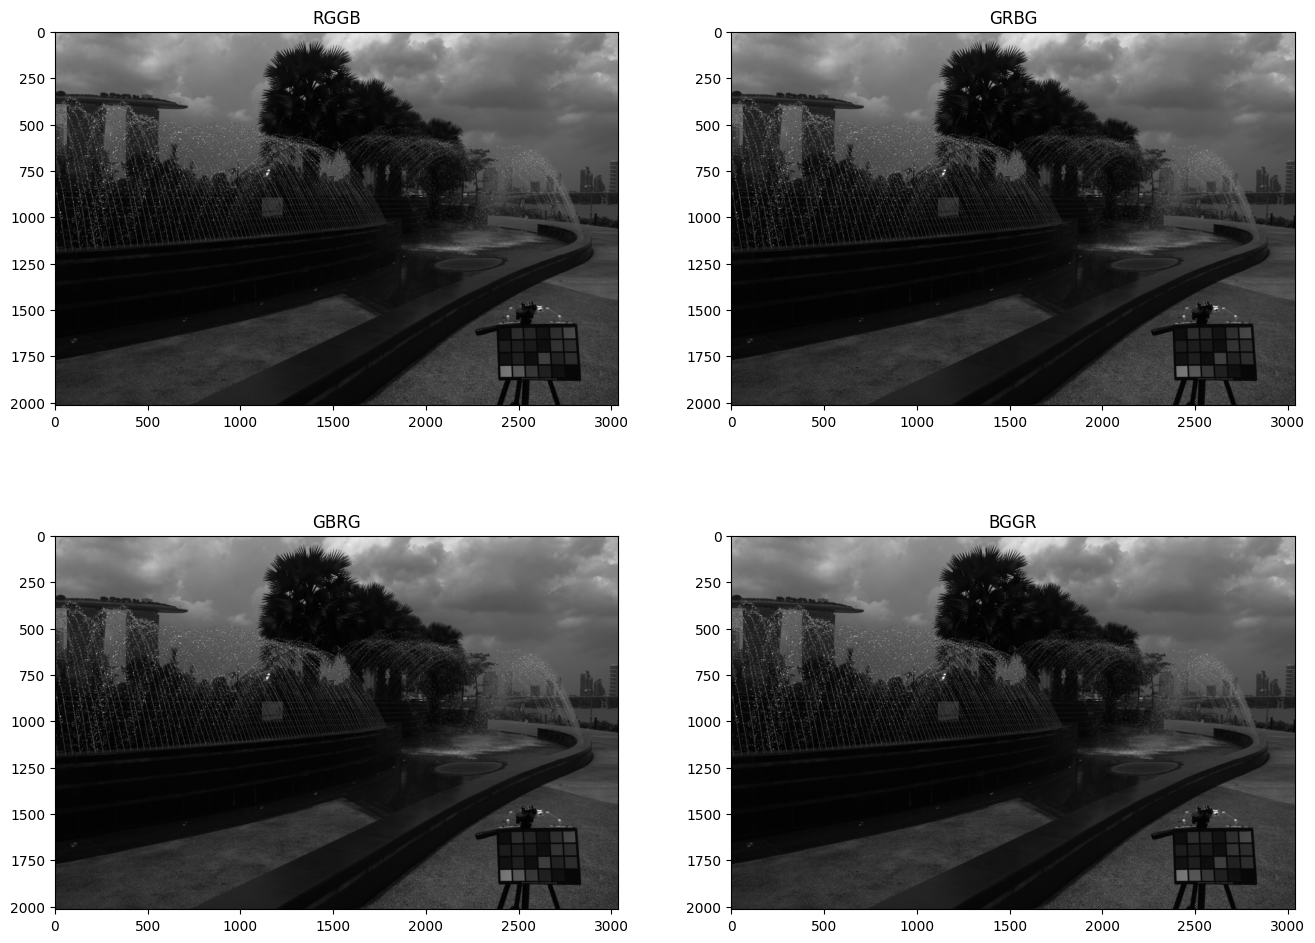

In [16]:
plt.figure(figsize=(16, 12))

for i, pattern in enumerate(images_without_demosaicing):
    plt.subplot(2, 2, i+1)
    plt.imshow(images_without_demosaicing[pattern][0], cmap='gray')
    plt.title(pattern.upper())

plt.show()

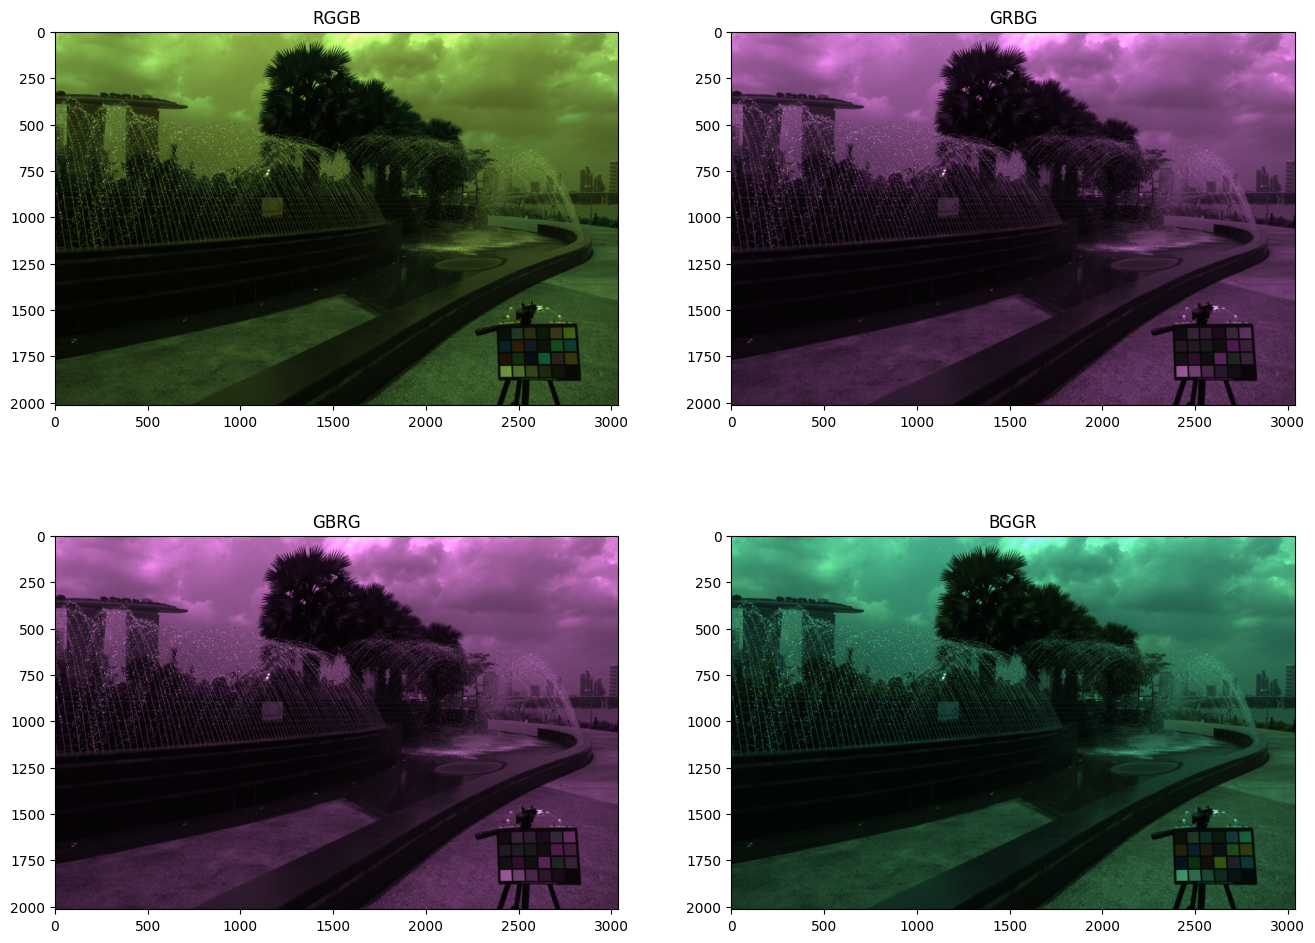

In [17]:
plt.figure(figsize=(16, 12))

for i, pattern in enumerate(images_without_demosaicing):
    img = demosaic_bilinear(images_without_demosaicing[pattern][0], pattern)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(pattern.upper())

plt.show()

Testing Gray World Assumption:

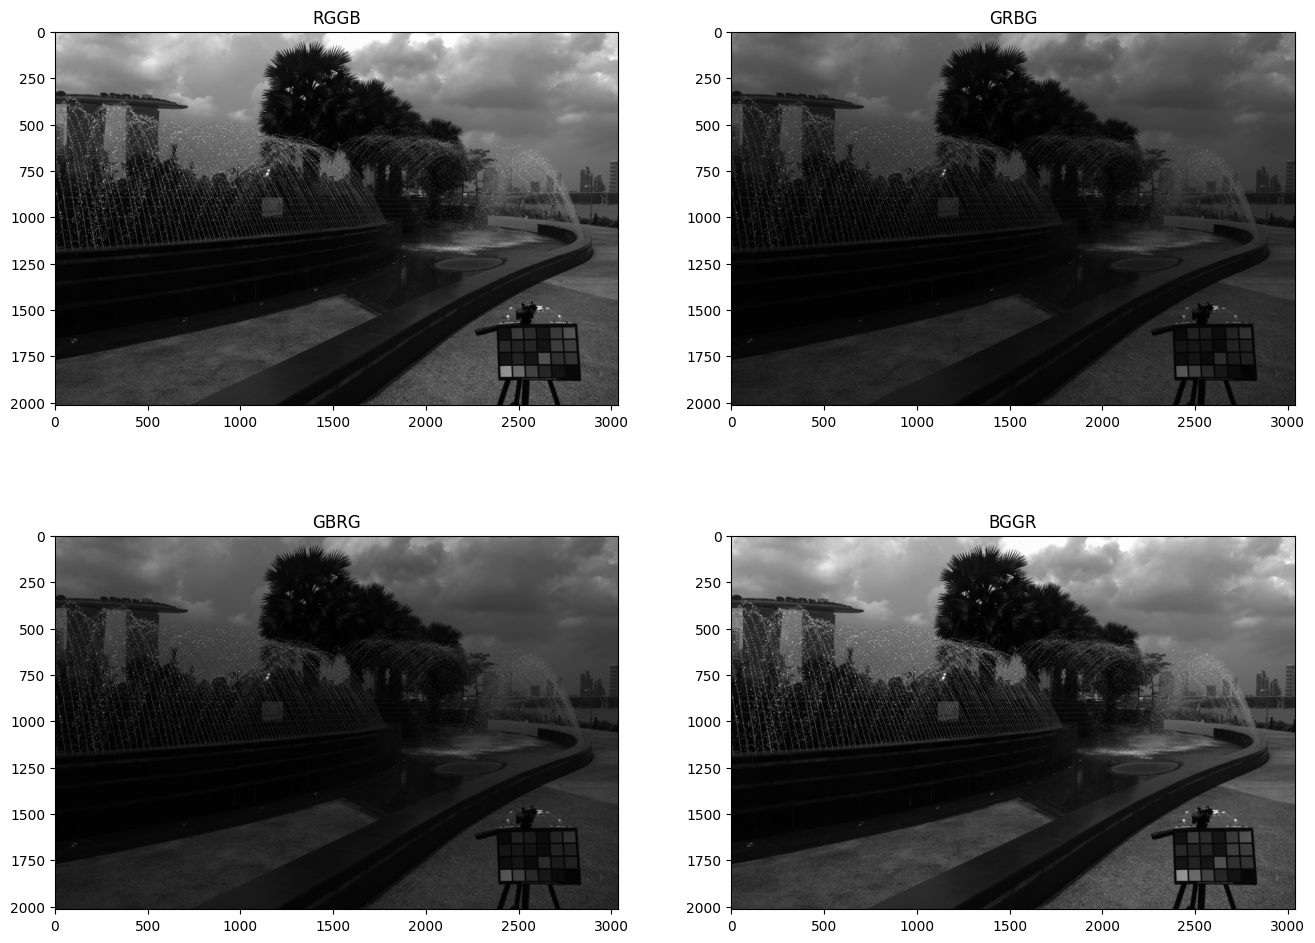

In [18]:
plt.figure(figsize=(16, 12))

for i, pattern in enumerate(images_without_demosaicing):
    plt.subplot(2, 2, i+1)
    plt.imshow(images_without_demosaicing[pattern][1], cmap='gray')
    plt.title(pattern.upper())

plt.show()

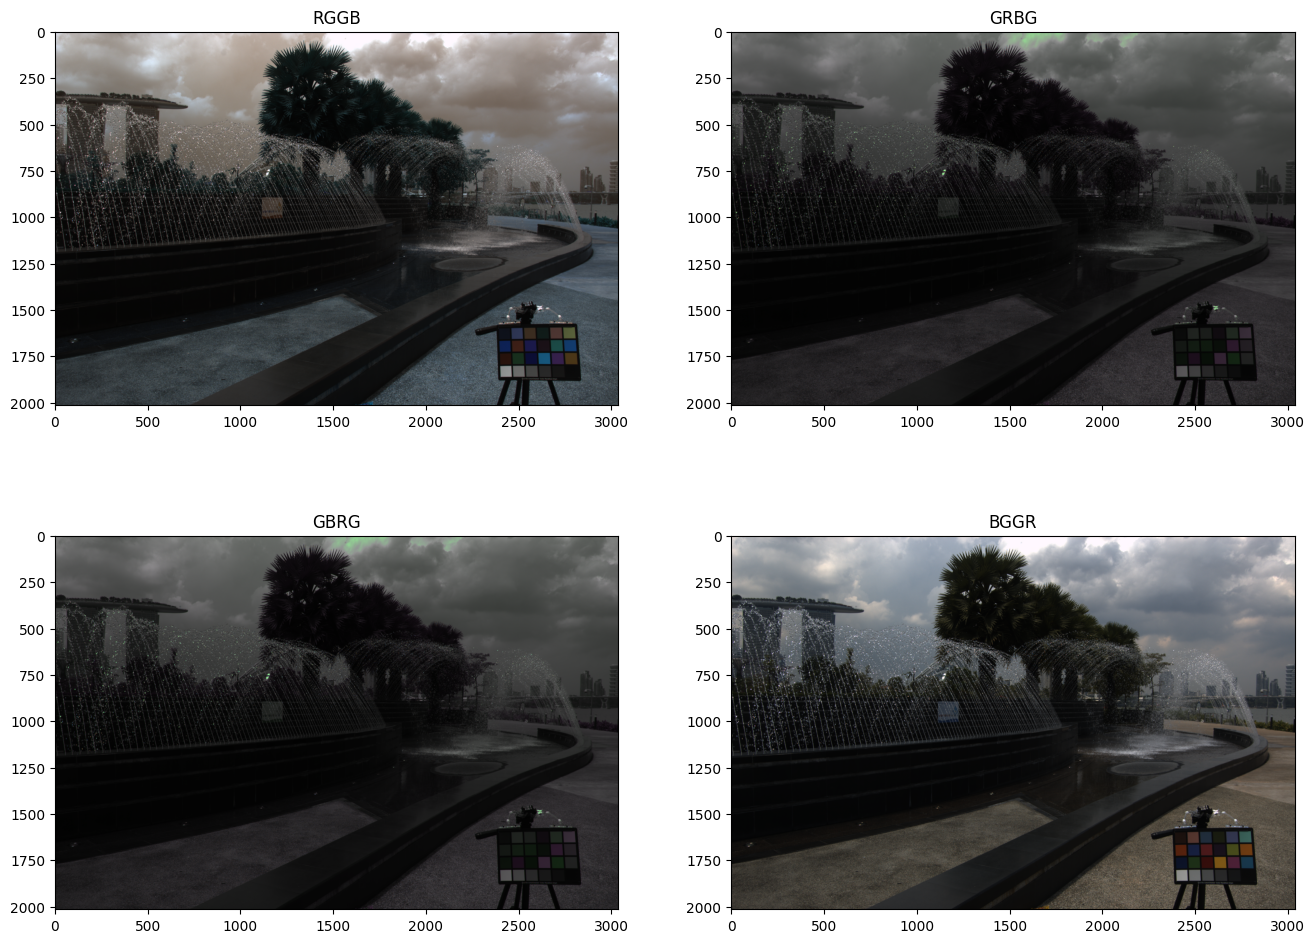

In [19]:
plt.figure(figsize=(16, 12))

for i, pattern in enumerate(images_without_demosaicing):
    img = demosaic_bilinear(images_without_demosaicing[pattern][1], pattern)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(pattern.upper())

plt.show()

Testing Preset Balancing:

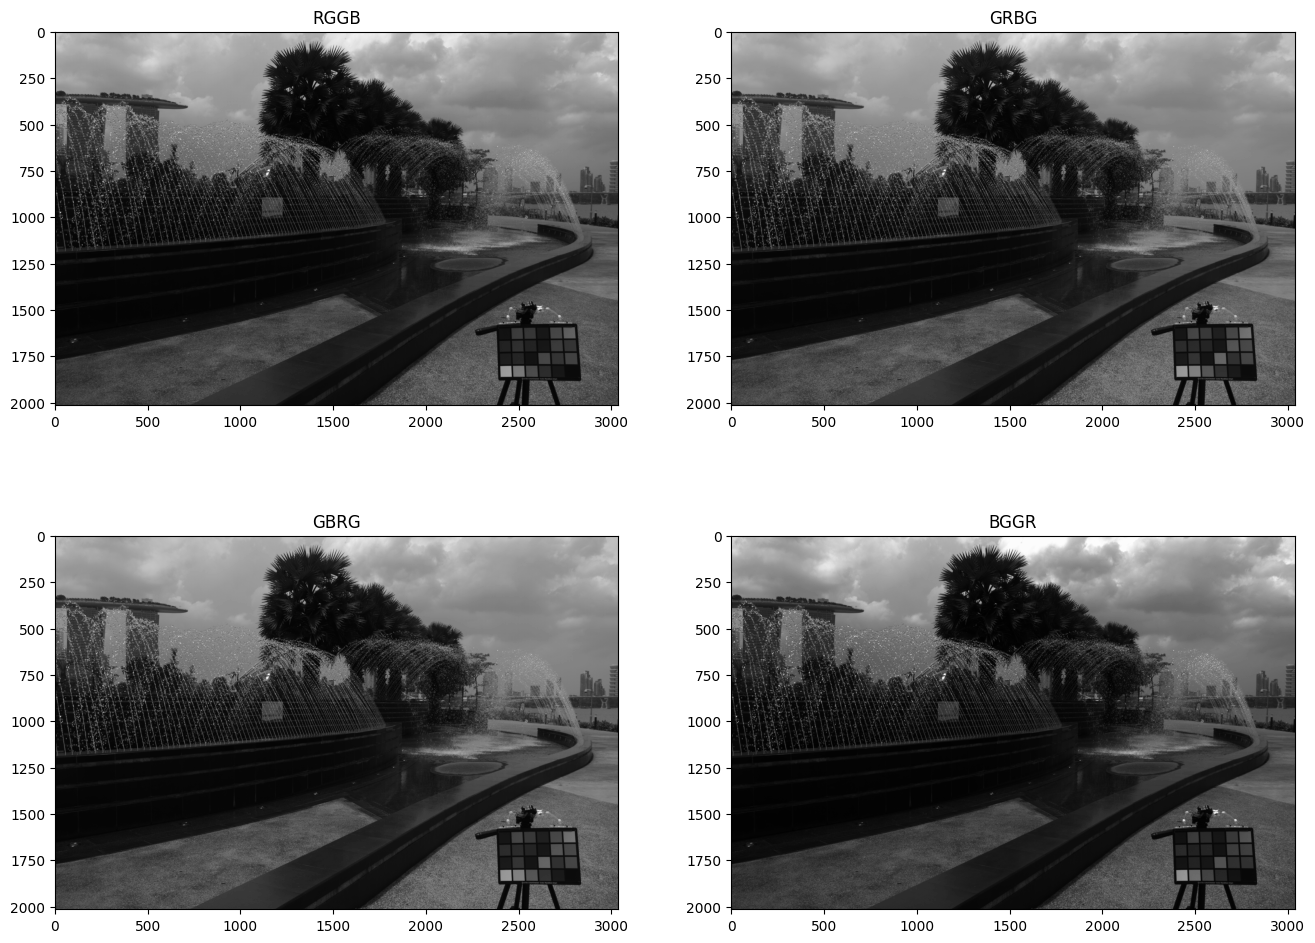

In [20]:
plt.figure(figsize=(16, 12))

for i, pattern in enumerate(images_without_demosaicing):
    plt.subplot(2, 2, i+1)
    plt.imshow(images_without_demosaicing[pattern][2], cmap='gray')
    plt.title(pattern.upper())

plt.show()

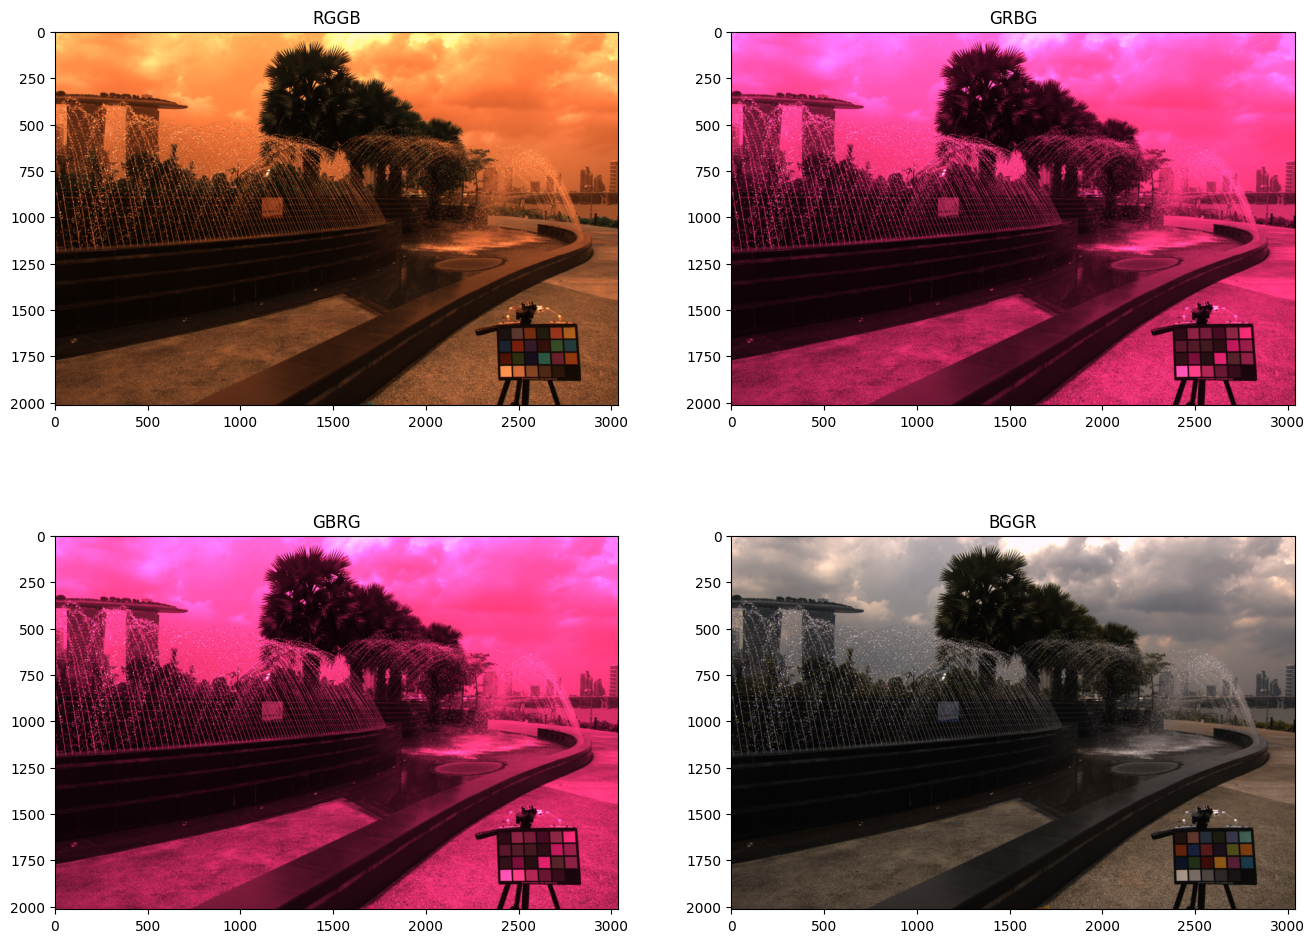

In [21]:
plt.figure(figsize=(16, 12))

for i, pattern in enumerate(images_without_demosaicing):
    img = demosaic_bilinear(images_without_demosaicing[pattern][2], pattern)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(pattern.upper())

plt.show()

Examining these 24 experiments (mostly the 12 with demosaicing) I decided on the BGGR pattern. I can list my reasons like this:
* For un-demosaiced images of gray world assumption experiment, GRBG and GBRG procude mostly garbage images. Whites don't make any sense.
* For the demosaiced part of the same experiment, BGGR just looks the best and closest to the actual image.
* For the white balancing with the device preset, the mosaic of the BGGR filter most accurate whites and white/gray separation for the clouds.
* For the last experiment (device preset white balancing with demosaicing) we almost get the actual image with the BGGR filter.

Thus, I choose BGGR pattern.

In [22]:
image = demosaic_bilinear(images_without_demosaicing['bggr'][2], 'bggr')

### 1.6. Color space correction. (10 points)
#### Transform your image to the linear sRGB color space. For this, you need to compute $M_{cam\rightarrow sRGB}$ matrix as explained in the homework text.

In the source code of dcraw.c:

...

{ "Nikon D40", 0, 0,
	{ 6992,-1668,-806,-8138,15748,2543,-874,850,7897 } },
    
...

In [23]:
# obtaining the required format
xyz_to_cam = np.array([
    [6992, -1668, -806],
    [-8138, 15748, 2543],
    [-874, 850, 7897]
])

xyz_to_cam = xyz_to_cam / 10000

In [24]:
xyz_to_cam

array([[ 0.6992, -0.1668, -0.0806],
       [-0.8138,  1.5748,  0.2543],
       [-0.0874,  0.085 ,  0.7897]])

In [25]:
srgb_to_xyz = np.array([
    [0.4124564, 0.3575761, 0.1804375],
    [0.2126729, 0.7151522, 0.0721750],
    [0.0193339, 0.1191920, 0.9503041]
])

In [26]:
srgb_to_cam = xyz_to_cam @ srgb_to_xyz
srgb_to_cam

array([[ 0.25135736,  0.12112295,  0.0375286 ],
       [ 0.00417688,  0.86553678,  0.20848349],
       [-0.00270351,  0.12366171,  0.74081979]])

In [27]:
srgb_to_cam_normalized = srgb_to_cam / srgb_to_cam.sum(axis=1, keepdims=True)
srgb_to_cam_normalized

array([[ 0.61305342,  0.2954154 ,  0.09153118],
       [ 0.00387394,  0.80276301,  0.19336305],
       [-0.00313713,  0.14349602,  0.85964112]])

In [28]:
cam_to_srgb = np.linalg.inv(srgb_to_cam_normalized)
cam_to_srgb

array([[ 1.63472849, -0.59436157, -0.04036692],
       [-0.00971646,  1.30141523, -0.29169877],
       [ 0.00758762, -0.21940841,  1.21182079]])

In [29]:
image.shape

(2014, 3039, 3)

In [30]:
image = image.reshape(-1, 3)
image.shape

(6120546, 3)

In [31]:
image = image @ cam_to_srgb.T
image = image.reshape(2014, 3039, 3)
image = np.clip(image, 0, 1, out=image)

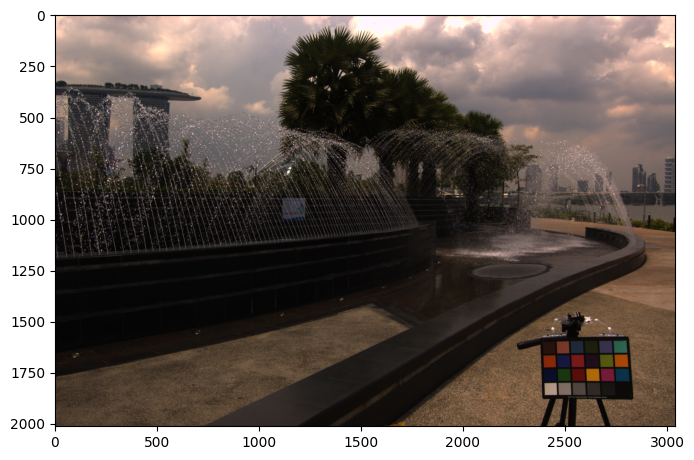

In [45]:
plt.figure(figsize=(8, 6))

plt.imshow(image)
plt.show()

### 1.7. Brightness adjustment and gamma encoding. (10 points)

In [32]:
## Experiment with different scaling values in the range [0, 1]. After scaling, clip all intensity values greater than 1 to 1.

#### Report your choice for scaling value here

In [33]:
## Apply non-linear gamma encoding

### 1.8. Compression (5 points)

In [34]:
## Use skimage's imsave function to store the image in .png format (no compression), and also in .jpeg format with the quality
## parameter set to 95

In [35]:
## Compute the compression ratio

#### Comment on the difference between files and state the compression ratio

In [36]:
## Show the images with different JPEG quality settings to determine the lowest setting for which the compressed image is
## indistinguishable from the original.

#### State the quality setting you have chosen and the corresponding compression ratio.

## 2.Perform manual white balancing (10 points)

#### See matplotlib function ginput to select image coordinates interactively.
#### Select some pathces in the scene you expect to be white and experiment on them appling the explained in the homework text. Experimenting with a few pathces suffices.

In [37]:
## Select patches in the scene you expect to be white. (Hint: Use ginput)

In [38]:
## Implement the algorithm in the HW text possibly with function(s)

#### Experiment with patch 1

In [39]:
## Normalize all three channels using weights that make the R, G, B channel values of this patch equal

In [40]:
## Show the corresponding resulting image after applying the necessary steps needed to get a properly displayable image.

#### Experiment with patch 2

In [41]:
## Normalize all three channels using weights that make the R, G, B channel values of this patch equal

In [42]:
## Show the corresponding resulting image after applying the necessary steps needed to get a properly displayable image.

## 3. Learn to use dcraw (10 points)

#### Reading the dcraw documentation, report the correct values for flags for the image processing pipeline you have implemented here.

#### You have at least three different images, namely, (1) at least one produced in the image processing pipeline you implemented, (2) produced using dcraw, and (3) image provided in the assignment data folder. Compare, explain the differences among them, and state your favorite one.
* Please add these images here. For this, you can use the following:
```python
from IPython.display import Image
```